<a href="https://www.kaggle.com/code/ahmadibraheeem/predicting-temperature-in-london-mlflow?scriptVersionId=148943729" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install mlflow
!pip install pandas scikit-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.0 MB/s eta 0:00:00


In [2]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Analysis Phase

In [3]:
Weather = pd.read_csv("/kaggle/input/london-weather-data/london_weather.csv")
Weather.head()
#Weather.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [4]:
Weather['snow_depth']

0        9.0
1        8.0
2        4.0
3        2.0
4        1.0
        ... 
15336    NaN
15337    NaN
15338    NaN
15339    NaN
15340    NaN
Name: snow_depth, Length: 15341, dtype: float64

In [5]:
Weather.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [6]:
nan_count = Weather.isna().sum()
nan_count

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [7]:
Weather = Weather.fillna(Weather.mean())

In [8]:
nan_count = Weather.isna().sum()
nan_count

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [9]:
Weather['date'] = pd.to_datetime(Weather['date'],format="%Y%m%d")
Weather['day'] = Weather['date'].dt.day
Weather['month'] = Weather['date'].dt.month
Weather['year'] = Weather['date'].dt.year
Weather = Weather.drop('date', axis=1)
Weather.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,day,month,year
0,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1,1979
1,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,2,1,1979
2,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,3,1,1979
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,4,1,1979
4,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,5,1,1979


In [10]:
corr_metrics = Weather.corr()
corr_metrics.style.background_gradient()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,day,month,year
cloud_cover,1.000000,-0.737884,-0.484820,-0.211913,-0.110273,0.048763,0.235058,-0.241651,-0.001185,0.011674,-0.020247,-0.106864
sunshine,-0.737884,1.000000,0.849974,0.472112,0.396130,0.219076,-0.231602,0.226924,-0.032330,-0.006969,-0.033842,0.009163
global_radiation,-0.484820,0.849974,1.000000,0.689729,0.633862,0.477701,-0.162590,0.150027,-0.058045,-0.003041,-0.092200,0.008390
max_temp,-0.211913,0.472112,0.689729,1.000000,0.911442,0.810284,-0.071798,0.100419,-0.123654,0.008912,0.183816,0.086271
mean_temp,-0.110273,0.396130,0.633862,0.911442,1.000000,0.954532,-0.010455,0.004758,-0.147051,0.009544,0.226806,0.093647
min_temp,0.048763,0.219076,0.477701,0.810284,0.954532,1.000000,0.037229,-0.074259,-0.150163,0.011499,0.251753,0.094587
precipitation,0.235058,-0.231602,-0.162590,-0.071798,-0.010455,0.037229,1.000000,-0.349362,-0.001284,0.006900,0.034344,0.008020
pressure,-0.241651,0.226924,0.150027,0.100419,0.004758,-0.074259,-0.349362,1.000000,-0.020531,0.007941,-0.039766,-0.013309
snow_depth,-0.001185,-0.032330,-0.058045,-0.123654,-0.147051,-0.150163,-0.001284,-0.020531,1.000000,-0.030345,-0.055355,-0.040916
day,0.011674,-0.006969,-0.003041,0.008912,0.009544,0.011499,0.006900,0.007941,-0.030345,1.000000,0.010457,0.000045


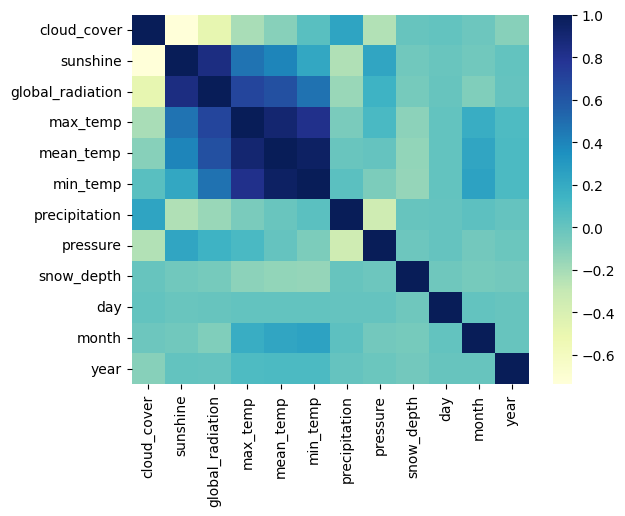

In [11]:
import seaborn as sns
sns.heatmap(Weather.corr(),cmap="YlGnBu")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# Features and label
X = Weather.drop('mean_temp', axis=1)
y = Weather['mean_temp']

# Splitting temp data into validate and test sets (each 10% of the original data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)  # 80% training, 20% testing

In [13]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler 

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
#X_train

Text(0.5, 0, 'Principal Component #')

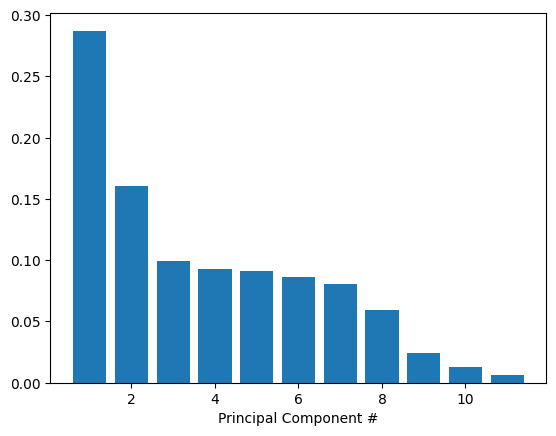

In [15]:
from sklearn.decomposition import PCA
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca = pca.fit(X_train)
exp_variance = pca.explained_variance_ratio_
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(1, len(exp_variance) + 1), exp_variance)
ax.set_xlabel('Principal Component #')

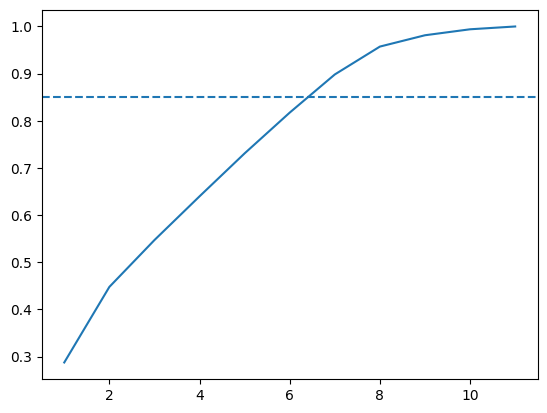

In [16]:
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance
# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_exp_variance) + 1),cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [17]:
from sklearn.decomposition import PCA
# Get our explained variance ratios from PCA using all features
pca = PCA(n_components=7)
# Fit and transform the scaled training features using pca
X_train = pca.fit_transform(X_train)

# Fit and transform the scaled test features using pca
X_test = pca.transform(X_test)

# Exploratory Analysis Conclusion

### After Exploring the data we will Embed the preprocessing steps in a pipeline

### After experimenting with dimentionality reduction using only 7 components Vs using all components I got the following stats:

| Metric                          | Linear Regression | Random Forest | XGBoost  |
|---------------------------------|-------------------|---------------|----------|
| **RMSE (All components)**       | 0.9154            | 1.2302        | 1.232    |
| **RMSE (Only 7 components)**    | 1.2690            | 1.0745        | 1.0425   |
| **MAE (All components)**        | 0.6868            | 0.8239        | 0.7926   |
| **MAE (Only 7 components)**     | 0.9775            | 0.9508        | 0.9484   |
| **R^2 (All components)**        | 0.9742            | 0.9645        | 0.9666   |
| **R^2 (Only 7 components)**     | 0.9505            | 0.9534        | 0.9533   |

### Therefore, we will proceed with including all components to get a better R^2 and a lower Error

# Creating the Preprocessing pipeline

In [18]:
# Loading the data one more time for the Pipeline
WeatherPL = pd.read_csv("/kaggle/input/london-weather-data/london_weather.csv")
WeatherPL.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [19]:
# Defining the Pipeline Function and Embedding the preprocessing steps in it
def preprocessing_pipeline(data):
    
    # Handle missing values
    data = data.fillna(data.mean())
    
    # Convert 'date' column to datetime and extract day, month, and year
    data['date'] = pd.to_datetime(data['date'], format="%Y%m%d")
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data = data.drop('date', axis=1)
    
    # Split data into features and label
    X = data.drop('mean_temp', axis=1)
    y = data['mean_temp']
    
    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    # Get our explained variance ratios from PCA using all features
    pca = PCA(n_components=7)
    # Fit and transform the scaled training features using pca
    X_train = pca.fit_transform(X_train)
    # Fit and transform the scaled test features using pca
    X_test = pca.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Let's showcase the pipeline function

X_train, X_test, y_train, y_test = preprocessing_pipeline(WeatherPL)
# Displaying the first 5 rows of the preprocessed data
X_train[:5], y_train[:5]

(array([[-4.49975591,  1.17055433,  0.49117744,  0.80713879,  0.39941587,
         -0.15748606, -0.71002992],
        [-0.52297567,  0.90434734,  0.07416179,  0.73052148, -0.9258211 ,
         -0.60945434,  0.33843644],
        [ 1.15839113,  2.61833307,  0.37962359, -1.86804173, -0.56108049,
         -0.26128397, -0.06924095],
        [ 1.44711144,  0.78194507,  0.55977095,  0.07498544, -0.1973185 ,
         -0.84088084,  0.17997336],
        [-1.28847498, -1.07145194, -0.46591902, -0.98222036,  0.26291916,
          0.59154629,  0.38695224]]),
 4209     18.3
 4098     11.1
 13529     1.8
 6282      2.4
 12646    20.2
 Name: mean_temp, dtype: float64)

In [20]:
from sklearn.linear_model import LinearRegression

# Training the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
pred_labels_lr = linear_model.predict(X_test)
pred_labels_lr


array([15.89380559, 15.31571811, 13.75212798, ...,  4.34420822,
        3.00498004,  6.10401139])

In [21]:
# Let's investigate the first few rows of X_train to see the structure of the data and confirm if 'date' column exists
X_train


array([[-4.49975591,  1.17055433,  0.49117744, ...,  0.39941587,
        -0.15748606, -0.71002992],
       [-0.52297567,  0.90434734,  0.07416179, ..., -0.9258211 ,
        -0.60945434,  0.33843644],
       [ 1.15839113,  2.61833307,  0.37962359, ..., -0.56108049,
        -0.26128397, -0.06924095],
       ...,
       [-0.24111082, -0.97072293,  0.60844717, ...,  1.35357179,
         0.09564484, -1.07365195],
       [ 0.5185027 , -1.71592241,  0.40005891, ...,  0.48712153,
        -1.21364005,  0.5834063 ],
       [ 1.61643876, -0.23231156, -1.74516346, ..., -0.60685713,
         1.0354932 , -0.09276655]])

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
pred_labels_rfr = rf_model.predict(X_test)
pred_labels_rfr

array([14.98675511, 15.08      , 13.2       , ...,  4.23451023,
        3.285     ,  5.887     ])

In [23]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
pred_labels_xgb = xgb_model.predict(X_test)
pred_labels_xgb

array([15.561969 , 16.265594 , 13.097762 , ...,  4.0715137,  3.2115157,
        6.229536 ], dtype=float32)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluations
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

rmse_linear = np.sqrt(mse_linear)
rmse_rf = np.sqrt(mse_rf)
rmse_xgb = np.sqrt(mse_xgb)

print("Linear Regression RMSE:", rmse_linear)
print("Random Forest RMSE:", rmse_rf)
print("XGBoost RMSE:", rmse_xgb)

# Additional Regression Metrics
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

r2_linear = r2_score(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nLinear Regression MAE:", mae_linear)
print("Random Forest MAE:", mae_rf)
print("XGBoost MAE:", mae_xgb)

print("\nLinear Regression R^2:", r2_linear)
print("Random Forest R^2:", r2_rf)
print("XGBoost R^2:", r2_xgb)

Linear Regression RMSE: 1.2690482550636712
Random Forest RMSE: 1.2302632839480885
XGBoost RMSE: 1.2327159492408375

Linear Regression MAE: 0.9775799199461688
Random Forest MAE: 0.9508877377754742
XGBoost MAE: 0.9484354695319765

Linear Regression R^2: 0.9505166790446609
Random Forest R^2: 0.9534951024266061
XGBoost R^2: 0.9533094923279559


In [25]:
y_pred_rf.mean()

11.438310899470086



#### Interpretation of the Relative Error:

Given the RMSE and MAE values:

RMSE:

Linear Regression: 0.9154

Random Forest: 0.9035

XGBoost: 0.9116

MAE:

Linear Regression: 0.6868

Random Forest: 0.6756

XGBoost: 0.6818

Since the mean value of the labels (i.e., mean_temp) is 11.44
For the Random Forest model, an RMSE of 0.9035 means that, on average, the model's predictions deviate from the actual values by about 0.9035 units. Given the average mean_temp of 11.44, this represents an error of approximately

#### Root Mean Squared Error = (0.9035*100)/11.44 ≈ 7.9% of the mean value.
 
Similarly, an MAE of 0.6756 represents an average error of approximately 

#### Mean Average Error = (0.6756*100)/11.44 ≈ 5.9% of the mean value.
 
### Error Magnitude:

The errors represented by RMSE and MAE are relatively small compared to the mean value of the labels. If the average temperature is 11.44 units (e.g., degrees Celsius), being off by 0.6756 to 0.9154 units on average is relatively small, indicating that the models are performing reasonably well.
Comparing Models:

Given the mean value context, the differences in RMSE and MAE among the models are still not very significant. All three models have errors that are a small percentage of the mean value, with the **Random Forest model performing slightly better than the others**.

In summary, with the mean value of the labels being 11.44, the RMSE and MAE values suggest that the models are doing a good job in predicting the mean_temp. The prediction errors are a small percentage of the average temperature, indicating reasonably accurate predictions. However, the "goodness" of these values still depends on the specific application and the acceptable margin of error for your use case.